In [2]:
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn opencv-python
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
# import os 
# print(os.path.join(os.getcwd(),"RealWaste"))

c:\AIS\Trio-Trashy_RealWaste_Classification\Trio-Trashy_RealWaste_Classification\model_training_python\RealWaste


In [3]:
# -----------------------------
# 1. IMPORTS
# -----------------------------
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, auc
)

from torchvision import transforms, models
from torchvision.models import mobilenet_v2


In [ ]:
# -----------------------------
# 2. DATASET PATH (LOCAL)
# -----------------------------
data_dir = os.path.join(os.getcwd(),"RealWaste")   # ✅ Update this to match your Jupyter folder name

class_names = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]

num_classes = len(class_names)

In [5]:
# -----------------------------
# 3. LOAD IMAGE PATHS
# -----------------------------
image_paths = []
labels = []

for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(class_dir, img_file))
                labels.append(label)

print("✅ Total images detected:", len(image_paths))

✅ Total images detected: 4752


C:\Users\admin\AppData\Local\Temp\ipykernel_21380\2384180664.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Count", data=df_counts, palette="viridis")


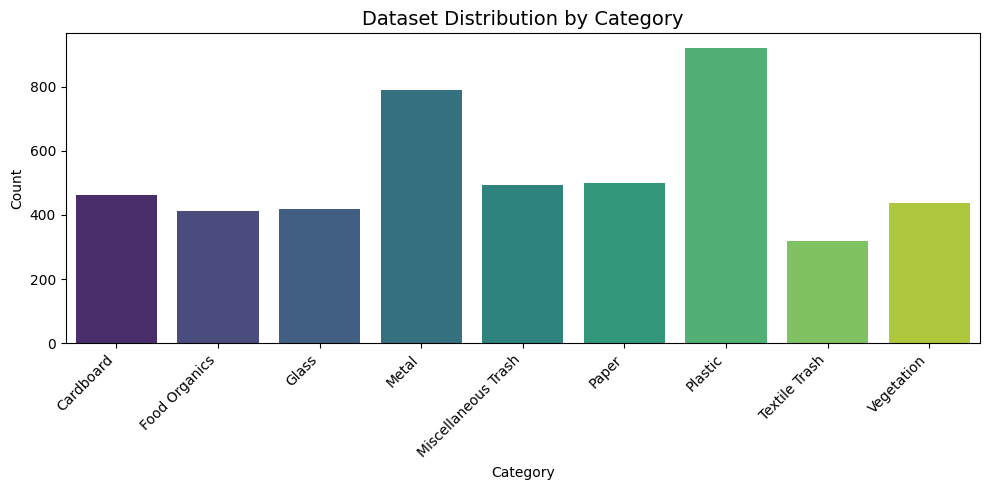

In [6]:
# ==========================================================
# 4. DATASET DISTRIBUTION ANALYSIS
# ==========================================================
label_counts = Counter(labels)
df_counts = pd.DataFrame(list(label_counts.items()), columns=["Category", "Count"])
plt.figure(figsize=(10,5))
sns.barplot(x="Category", y="Count", data=df_counts, palette="viridis")
plt.title("Dataset Distribution by Category", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


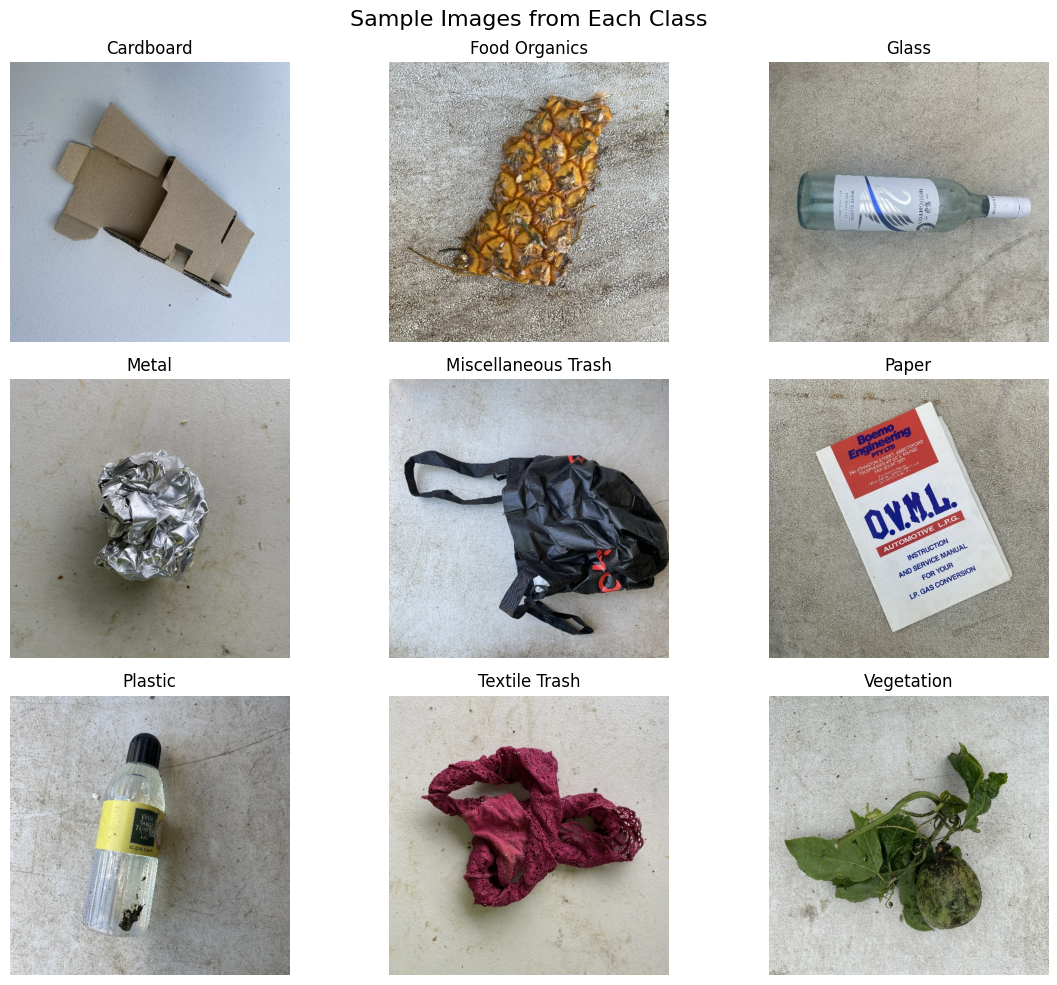

In [7]:
# ==========================================================
# 5. SHOW SAMPLE IMAGES FROM EACH CATEGORY
# ==========================================================
plt.figure(figsize=(12, 10))
for i, cls in enumerate(sorted(os.listdir(data_dir))[:9]):
    class_folder = os.path.join(data_dir, cls)
    img_file = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_file)
    img = Image.open(img_path).convert("RGB")
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
# ==========================================================
# 6. TRAIN / VAL / TEST SPLIT
# ==========================================================
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, random_state=42, stratify=labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.17647,
    random_state=42, stratify=train_val_labels
)

print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Testing images: {len(test_paths)}")


Training images: 3326
Validation images: 713
Testing images: 713


In [9]:
# ==========================================================
# 7. ENCODE LABELS
# ==========================================================
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels   = le.transform(val_labels)
test_labels  = le.transform(test_labels)

print("\n📚 Class Mapping:")
for i, c in enumerate(le.classes_):
    print(f"{i} → {c}")


📚 Class Mapping:
0 → Cardboard
1 → Food Organics
2 → Glass
3 → Metal
4 → Miscellaneous Trash
5 → Paper
6 → Plastic
7 → Textile Trash
8 → Vegetation


In [10]:
# ==========================================================
# 8. IMAGE TRANSFORMS
# ==========================================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
# ==========================================================
# 9. CUSTOM DATASET
# ==========================================================
class WasteDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        return img, self.labels[idx]

In [12]:
# ==========================================================
# 10. DATALOADERS
# ==========================================================
batch_size = 32

train_loader = DataLoader(WasteDataset(train_paths, train_labels, train_transform),
                          batch_size=batch_size, shuffle=True)

val_loader   = DataLoader(WasteDataset(val_paths, val_labels, test_transform),
                          batch_size=batch_size, shuffle=False)

test_loader  = DataLoader(WasteDataset(test_paths, test_labels, test_transform),
                          batch_size=batch_size, shuffle=False)

In [13]:
# ==========================================================
# 11. BUILD MODEL
# ==========================================================
def build_model(num_classes, lr=1e-4):
    model = mobilenet_v2(weights="IMAGENET1K_V1")

    # Freeze all layers
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze last 6 layers
    finetune = ['features.14','features.15','features.16','features.17','features.18']
    for name, param in model.named_parameters():
        if any(name.startswith(layer) for layer in finetune):
            param.requires_grad = True

    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.last_channel, num_classes)
    )

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

    return model, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer = build_model(num_classes)
model = model.to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
# ==========================================================
# 11. TRAIN + EVALUATE
# ==========================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            total_loss += criterion(out, labels).item()

            _, preds = torch.max(out, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )

    return {
        "loss": total_loss / len(loader),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true": y_true,
        "pred": y_pred
    }

In [15]:
# ==========================================================
# 12. TRAIN LOOP
# ==========================================================
def train_model(model, optimizer, train_loader, val_loader, device, epochs=25, patience=5):
    """
    Trains the given model with ReduceLROnPlateau and Early Stopping.
    Automatically restores best weights (lowest validation loss).
    """
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    best_val_loss = float('inf')
    best_weights = None
    epochs_no_improve = 0

    history = {"train_loss": [], "train_acc": [], "val_acc": [], "val_loss": []}

    print(f"🕓 Early stopping activated (patience={patience})")

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        # ---- Validation ----
        val_metrics = evaluate(model, val_loader, criterion, device)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["accuracy"]

        # ---- LR Scheduling ----
        scheduler.step(val_loss)

        # ---- Record Metrics ----
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # ---- Early Stopping ----
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹ Early stopping triggered at epoch {epoch+1} (no improvement for {patience} epochs).")
                break

    # ---- Restore Best Weights ----
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print(f"✅ Restored best model weights (val_loss = {best_val_loss:.4f})")

    return model, history

In [16]:
# ==========================================================
# 13. TRAIN MODEL
# ==========================================================
trained_model, history = train_model(
    model, optimizer, train_loader, val_loader, device,
    epochs=40, patience=5
)

🕓 Early stopping activated (patience=5)
Epoch 1/40 | Train Loss: 1.1779 | Train Acc: 0.6155 | Val Loss: 0.7404 | Val Acc: 0.7588
Epoch 2/40 | Train Loss: 0.6218 | Train Acc: 0.7892 | Val Loss: 0.5413 | Val Acc: 0.8050
Epoch 3/40 | Train Loss: 0.4617 | Train Acc: 0.8449 | Val Loss: 0.4303 | Val Acc: 0.8443
Epoch 4/40 | Train Loss: 0.3556 | Train Acc: 0.8845 | Val Loss: 0.4159 | Val Acc: 0.8780
Epoch 5/40 | Train Loss: 0.2911 | Train Acc: 0.9041 | Val Loss: 0.4028 | Val Acc: 0.8499
Epoch 6/40 | Train Loss: 0.2444 | Train Acc: 0.9179 | Val Loss: 0.3671 | Val Acc: 0.8710
Epoch 7/40 | Train Loss: 0.2031 | Train Acc: 0.9354 | Val Loss: 0.3512 | Val Acc: 0.8710
Epoch 8/40 | Train Loss: 0.1692 | Train Acc: 0.9483 | Val Loss: 0.3400 | Val Acc: 0.8738
Epoch 9/40 | Train Loss: 0.1535 | Train Acc: 0.9498 | Val Loss: 0.3849 | Val Acc: 0.8710
Epoch 10/40 | Train Loss: 0.1267 | Train Acc: 0.9600 | Val Loss: 0.3250 | Val Acc: 0.8934
Epoch 11/40 | Train Loss: 0.0983 | Train Acc: 0.9693 | Val Loss: 0.32

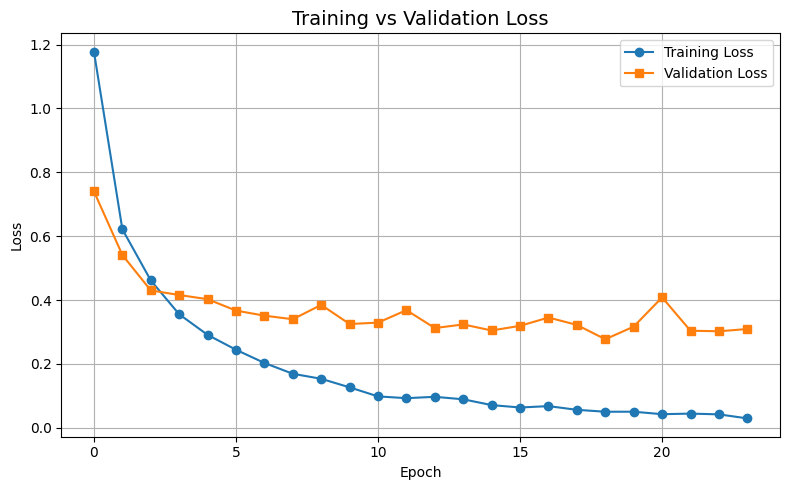

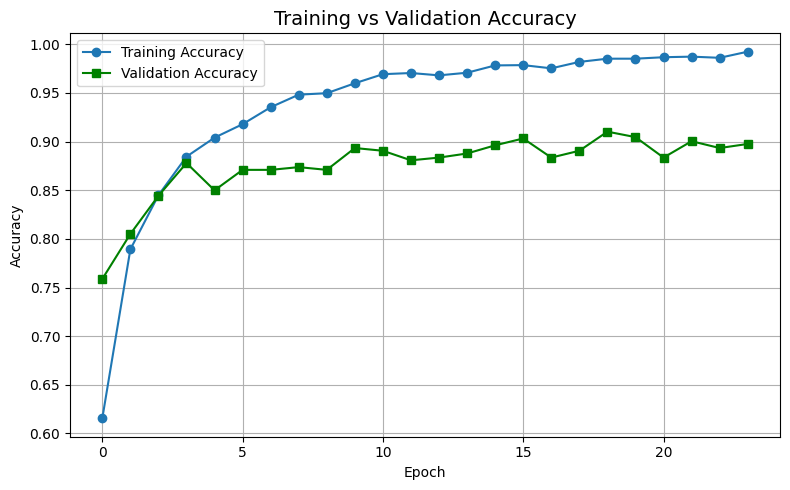

In [17]:
# ==========================================================
# 14. TRAINING CURVES
# ==========================================================
# --- 1️⃣ Training vs Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label="Training Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='s')
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2️⃣ Training vs Validation Accuracy ---
plt.figure(figsize=(8, 5))

# If your 'train_one_epoch' doesn’t return accuracy,
# we only have validation accuracy in `history["val_acc"]`.
# In that case, this will just show validation accuracy.
if "train_acc" in history:
    plt.plot(history["train_acc"], label="Training Accuracy", marker='o')

plt.plot(history["val_acc"], label="Validation Accuracy", marker='s', color='green')
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# ===========================================================
# 15. TEST EVALUATION
# ===========================================================
criterion = nn.CrossEntropyLoss()
test_metrics = evaluate(trained_model, test_loader, criterion, device)
print("\n📋 Classification Report:\n")
print(classification_report(test_metrics["true"], test_metrics["pred"], target_names=le.classes_))


📋 Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.93      0.91      0.92        69
      Food Organics       0.92      0.89      0.90        62
              Glass       0.85      0.97      0.90        63
              Metal       0.94      0.86      0.89       119
Miscellaneous Trash       0.78      0.73      0.76        74
              Paper       0.95      0.92      0.93        75
            Plastic       0.86      0.88      0.87       138
      Textile Trash       0.82      0.96      0.88        48
         Vegetation       0.97      0.97      0.97        65

           accuracy                           0.89       713
          macro avg       0.89      0.90      0.89       713
       weighted avg       0.89      0.89      0.89       713



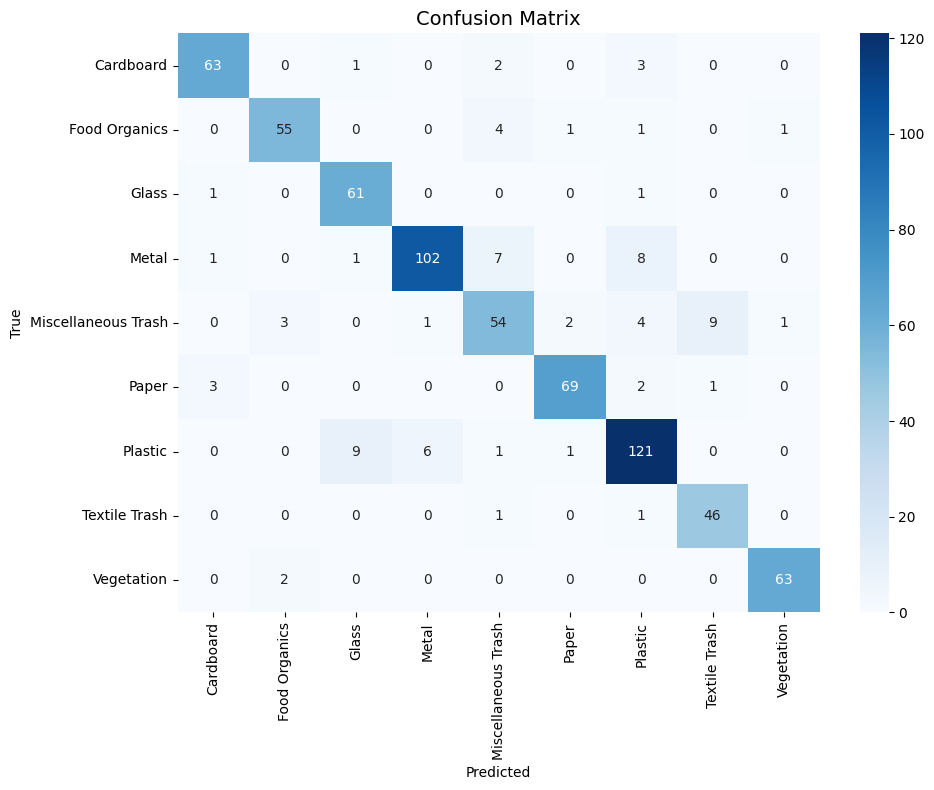

In [21]:
# ==========================================================
# 16. CONFUSION MATRIX
# ==========================================================
cm = confusion_matrix(test_metrics["true"], test_metrics["pred"])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_21380\4244657887.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=class_acc, palette="coolwarm")


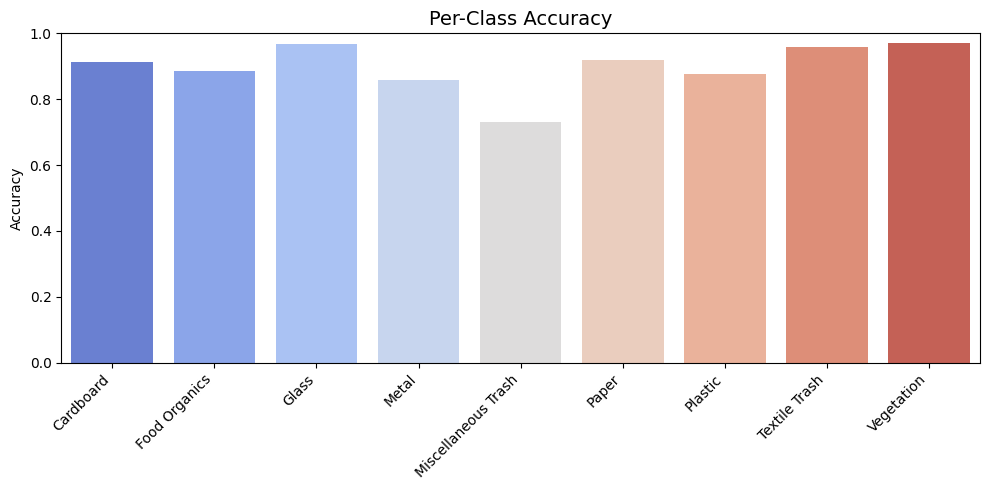

In [22]:
# ==========================================================
# 17. PER-CLASS ACCURACY
# ==========================================================
cm_sum = cm.sum(axis=1)
class_acc = np.diag(cm) / cm_sum
plt.figure(figsize=(10,5))
sns.barplot(x=le.classes_, y=class_acc, palette="coolwarm")
plt.title("Per-Class Accuracy", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

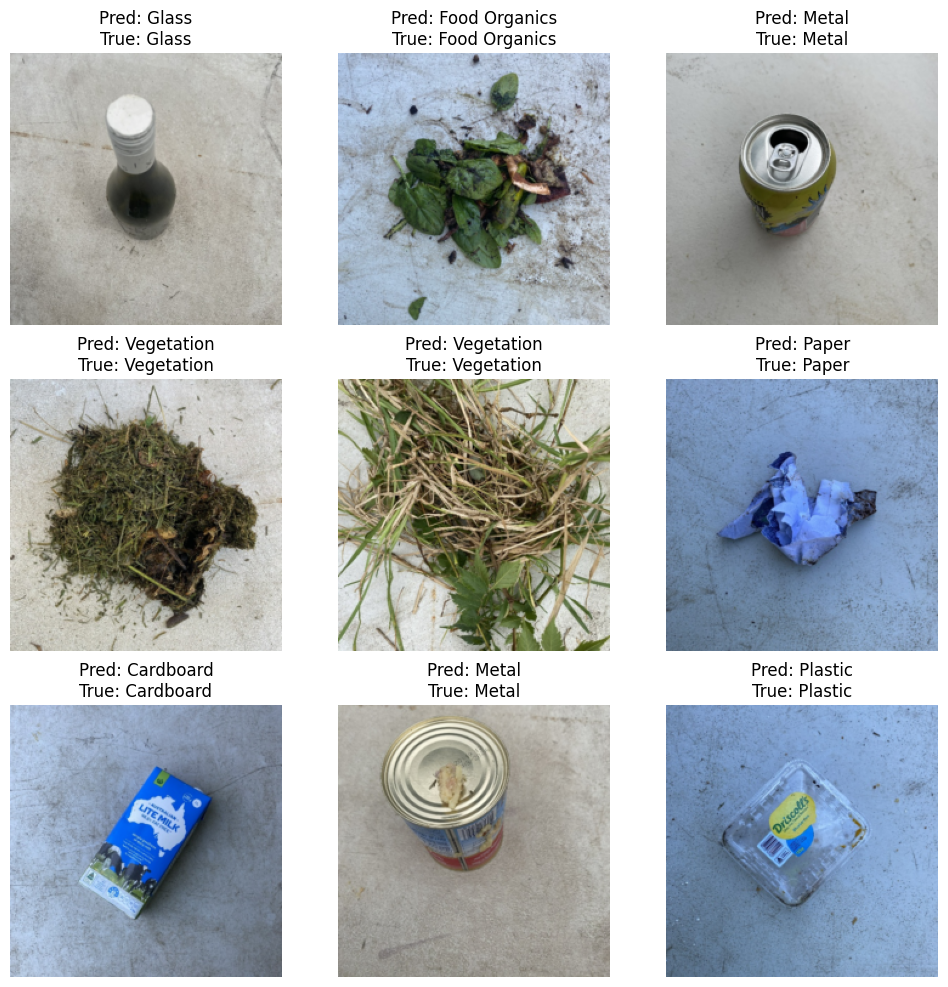

In [23]:
# ==========================================================
# 18. PREDICTION VISUALIZATION
# ==========================================================
def plot_predictions(model, loader, device, class_names):
    model.eval()
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(device), labels.to(device)

    out = model(imgs)
    _, preds = torch.max(out, 1)

    plt.figure(figsize=(12,12))
    for i in range(min(9, len(imgs))):
        img = imgs[i].cpu().permute(1,2,0).numpy()
        img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")

    plt.show()

plot_predictions(trained_model, test_loader, device, class_names)

In [24]:
# ==========================================================
# 19. SAVE MODEL
# ==========================================================
torch.save(trained_model.state_dict(), "mobilenetv2_final.pth")
print("✅ Model saved successfully.")

✅ Model saved successfully.


In [25]:
# ==========================================================
# 20. LOAD MODEL
# ==========================================================
model_reload, _ = build_model(num_classes)
model_reload.load_state_dict(torch.load("mobilenetv2_final.pth"))
model_reload.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=